# Red Sox Game Analysis

This file examines post-game entries at Kenmore station in comparison to expectations.

## Setup    

In [2]:
# Libraries.
import datetime as dt
import matplotlib, matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Feature libraries.
from features import date

In [3]:
# Package settings.

# Matplotlib.
%matplotlib inline

# Seaborn.
sns.set_style('darkgrid')

In [4]:

sns.set_style('white')

In [5]:
# Other settings.

# Stations near Fenway for analysis. Fenway station itself is not in the gatecount dataset.
# Just use names (not locationid) as a surrogate key for station name.
fenway_stations = ['Kenmore Square', 'Hynes']

# Base units of timedeltas.
timedelta_base = 3.6e12

# Default figure size.
default_figsize = (12,8)
default_figsize_slides = (12,6)

# Day of week mapping.
days_of_week = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

# Game length in hours for coloring.
game_length = 3+8./60

# Baseball season information.
# There are little edge cases regarding the playoffs/WS and such. Just use April through October to make things easiest.
season_start_month = 4
season_end_month   = 10
season_months = np.arange(season_start_month, season_end_month+1)

## Data

### Read

In [6]:
# Read Red Sox home games.
sox = pd.DataFrame.from_csv("../../../data/sox_master.csv").reset_index(drop=True)

# Rename other columns to make joining easy.
sox.rename(columns={'START_DATE':'game_date', 'START_TIME':'game_time', 'OPPONENT':'opponent'}, inplace=True)

# Drop 0s from start date.
sox.game_date = sox.game_date.str.extract('(\d+-\d+-\d+)')
# Column for start datetime.
sox['game_datetime'] = pd.to_datetime(sox.game_date + ' ' + sox.game_time)

# Add a "rounded" game time to make grouping easier.
sox['game_time_rounded'] = sox.game_time.str.replace(':[012][05] ',':00 ').str.replace(':[345][05] ',':30 ')
sox['game_datetime_rounded'] = pd.to_datetime(sox.game_date + ' ' + sox.game_time_rounded)

# Turn start date into a date.
sox.game_date = pd.to_datetime(sox.game_date)

# Convert time fields to times.
sox.game_time = pd.DatetimeIndex(sox.game_datetime).time
sox.game_time_rounded = pd.DatetimeIndex(sox.game_datetime_rounded).time

In [ ]:
sox.head()

In [ ]:
# Import gatecount data.
def get_data():
    return pd.DataFrame.from_csv("../../../data/mbta.csv").reset_index()
gatecount = date.init(get_data())

# Restrict to fields that we need.
clean_gatecount = gatecount[['locationid','name','line_1','line_2','service_day','service_datetime','entries']]

# Turn days/dates into datetimes.
clean_gatecount.service_day = pd.to_datetime(clean_gatecount.service_day)
clean_gatecount.service_datetime = pd.to_datetime(clean_gatecount.service_datetime)

# Get time of day.
clean_gatecount['service_time'] = pd.DatetimeIndex(clean_gatecount.service_datetime).time

# Add day of week.
clean_gatecount = date.add_day_of_week(clean_gatecount.copy())

# Drop gatecount.
del gatecount

In [ ]:
clean_gatecount.head()

### Merge

In [21]:
# Perform merge.
sox_gatecount = clean_gatecount.merge(sox, left_on='service_day', right_on='game_date', how='left')

# Flag days with games.
sox_gatecount['game_played'] = (sox_gatecount.opponent.isnull() == False)

# Calculate delta from game start to entries record time.
sox_gatecount['time_since_game_start'] = sox_gatecount.service_datetime - sox_gatecount.game_datetime_rounded

# Separate into classes: weekday/weekend and early/late.
sox_gatecount['day_of_week_class'] = 'Weekday'
sox_gatecount.ix[sox_gatecount.day_of_week >= 5,'day_of_week_class'] = 'Weekend'
sox_gatecount['game_time_class'] = 'Early'
sox_gatecount.ix[sox_gatecount.game_time_rounded >= dt.time(18),'game_time_class'] = 'Late'

In [60]:
sox_gatecount[sox_gatecount.game_played].head()

,locationid,name,line_1,line_2,service_day,service_datetime,entries,service_time,day_of_week,game_date,game_time,opponent,game_datetime,game_time_rounded,game_datetime_rounded,game_played,time_since_game_start,day_of_week_class,game_time_class
492838,1002,Andrew Square,Red,None,2013-04-08,2013-04-08 04:45:00,1,04:45:00,0,2013-04-08,14:05:00,Orioles,2013-04-08 14:05:00,14:00:00,2013-04-08 14:00:00,True,-1 days +14:45:00,Weekday,Early
492839,1002,Andrew Square,Red,None,2013-04-08,2013-04-08 05:00:00,8,05:00:00,0,2013-04-08,14:05:00,Orioles,2013-04-08 14:05:00,14:00:00,2013-04-08 14:00:00,True,-1 days +15:00:00,Weekday,Early
492840,1002,Andrew Square,Red,None,2013-04-08,2013-04-08 05:15:00,81,05:15:00,0,2013-04-08,14:05:00,Orioles,2013-04-08 14:05:00,14:00:00,2013-04-08 14:00:00,True,-1 days +15:15:00,Weekday,Early
492841,1002,Andrew Square,Red,None,2013-04-08,2013-04-08 05:30:00,57,05:30:00,0,2013-04-08,14:05:00,Orioles,2013-04-08 14:05:00,14:00:00,2013-04-08 14:00:00,True,-1 days +15:30:00,Weekday,Early
492842,1002,Andrew Square,Red,None,2013-04-08,2013-04-08 05:45:00,48,05:45:00,0,2013-04-08,14:05:00,Orioles,2013-04-08 14:05:00,14:00:00,2013-04-08 14:00:00,True,-1 days +15:45:00,Weekday,Early


## Game Exploration 

Let's figure out when games happen.

In [7]:
# Copy DF for this analysis.
sox_only = sox.copy()
# Restrict to 2013 and onward.
sox_only = sox_only[sox_only.game_date > dt.date(2013,1,1)]
# Add weekday.
sox_only['day_of_week'] = pd.DatetimeIndex(sox_only.game_date).weekday

# Also re-add some of the merged features from above.

# Separate into classes: weekday/weekend and early/late.
sox_only['day_of_week_class'] = 'Weekday'
sox_only.ix[sox_only.day_of_week >= 5,'day_of_week_class'] = 'Weekend'
sox_only['game_time_class'] = 'Early'
sox_only.ix[sox_only.game_time_rounded >= dt.time(18),'game_time_class'] = 'Late'

When do games occur during the week? **Monday is 0.**

In [8]:
games_by_dow = sox_only.groupby(['day_of_week']).agg({'game_time':len})
games_by_dow.columns = ['games']
# games_by_dow

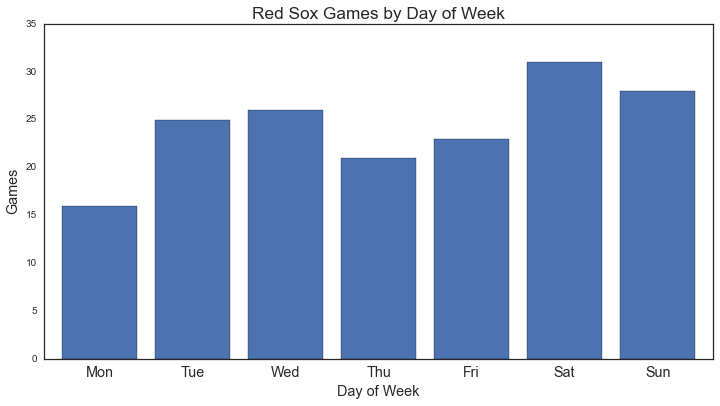

In [12]:
# Plot days of week.

# Start plotting.
plt.figure(figsize=default_figsize_slides)
plt.bar(games_by_dow.index, games_by_dow.games, width=0.8)

# Prettify.
plt.title('Red Sox Games by Day of Week', fontsize='xx-large')
plt.xlabel('Day of Week', fontsize='x-large'); plt.ylabel('Games', fontsize='x-large')
plt.xlim(-0.2,7)
plt.xticks(np.arange(0,7)+0.4, days_of_week, fontsize='x-large')

# Show.
plt.show()

Answer: pretty consistently throughout the week. Slightly more on weekends, Tuesday, and Wednesday.

What about during the day?

In [13]:
# Group and aggregate by time.
games_by_time = sox_only.groupby(['game_time']).agg({'opponent':len}).reset_index()
games_by_time.columns = ['game_time','games']
# Sort and handle am/pm oddness.
games_by_time.sort(inplace=True)
games_by_time = games_by_time.ix[-2:,:].append(games_by_time.ix[:-2,:]) 
# games_by_time

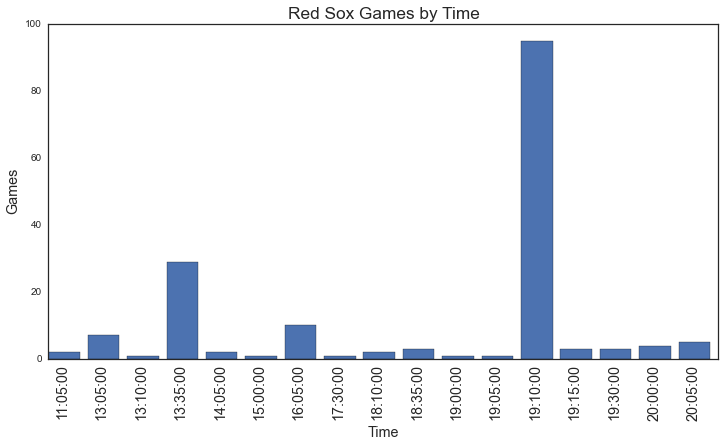

In [15]:
# Plot time.

# Start plotting.
plt.figure(figsize=default_figsize_slides)
plt.bar(np.arange(len(games_by_time)), games_by_time.games, width=0.8)

# Prettify.
plt.title('Red Sox Games by Time', fontsize='xx-large')
plt.xlabel('Time', fontsize='x-large'); plt.ylabel('Games', fontsize='x-large')
locs, labels = plt.xticks(np.arange(0,len(games_by_time))+0.4, games_by_time.game_time, fontsize='x-large')
plt.setp(labels,rotation=90)
plt.xlim(0,len(games_by_time))

# Show.
plt.show()

In [118]:
# Group and aggregate by rounded time.
games_by_time_rounded = sox_only.groupby(['game_time_rounded']).agg({'opponent':len}).reset_index()
games_by_time_rounded.columns = ['game_time_rounded','games']
# Sort and handle am/pm oddness.
games_by_time_rounded.sort(inplace=True)
games_by_time_rounded = games_by_time_rounded.ix[-2:,:].append(games_by_time_rounded.ix[:-2,:]) 
# games_by_time_rounded

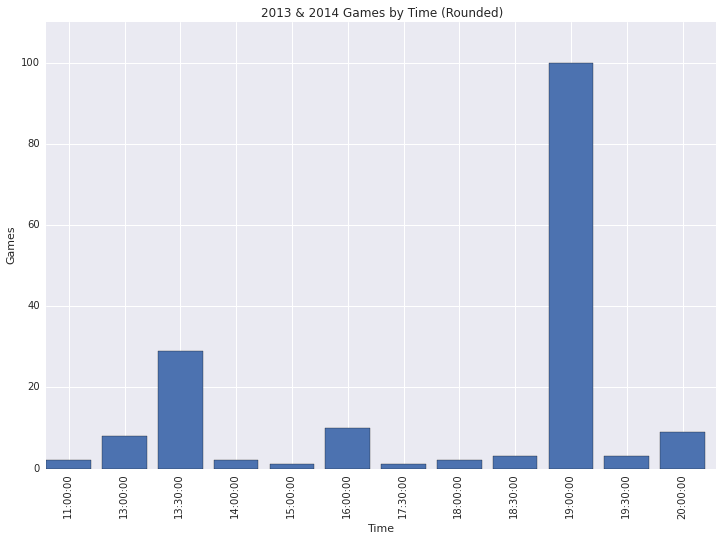

In [142]:
# Plot rounded time.

# Start plotting.
plt.figure(figsize=default_figsize)
plt.bar(np.arange(len(games_by_time_rounded)), games_by_time_rounded.games, width=0.8)

# Prettify.
plt.title('2013 & 2014 Games by Time (Rounded)')
plt.xlabel('Time'); plt.ylabel('Games')
locs, labels = plt.xticks(np.arange(0,len(games_by_time_rounded))+0.4, games_by_time_rounded.game_time_rounded)
plt.ylim(0,plt.ylim()[1]*1.1)
plt.setp(labels,rotation=90)

# Show.
plt.show()

Now both. Use rounded time to cut down on volume.

In [122]:
# Group and aggregate by rounded time.
games_by_datetime = sox_only.groupby(['day_of_week','game_time_rounded']).agg({'opponent':len})
games_by_datetime.columns = ['games']
games_by_datetime

games
day_of_week game_time_rounded       
0           11:00:00               2
            13:30:00               1
            14:00:00               1
            18:00:00               1
            18:30:00               1
            19:00:00              10
1           13:00:00               1
            18:00:00               1
            18:30:00               1
            19:00:00              21
            20:00:00               1
2           13:30:00               2
            16:00:00               3
            19:00:00              19
            19:30:00               2
3           13:00:00               1
            13:30:00               1
            16:00:00               2
            18:30:00               1
            19:00:00              15
            19:30:00               1
4           14:00:00               1
            15:00:00               1
            19:00:00              21
5           13:00:00               6
            13:30:00               5
            16:00:00               5
            17:30:00               1
            19:00:00              12
            20:00:00               2
6           13:30:00              20
            19:00:00               2
            20:00:00               6

Primetime games are common throughout, except for Sunday. Instead, Sunday features a lot of early afternoon games. As expected, weekdays don't show many afternoon games, though Friday shows more than other weekdays (at various times). It looks like primetime games Monday-Saturday and Sunday afternoon games show the highest potential.

In [123]:
# One more: group and aggregate by rounded time.
games_by_datetime = sox_only.groupby(['day_of_week_class','game_time_class']).agg({'opponent':len})
games_by_datetime.columns = ['games']
games_by_datetime

games
day_of_week_class game_time_class       
Weekday           Early               16
                  Late                95
Weekend           Early               37
                  Late                22

## Game/Entries Exploration

### Aggregate, Controlling for Day of Week

Now let's control for day of week. I.e., we don't want to compare entries at 10pm on a gameday Monday with an average that includes Saturday.

In [92]:
# Get hourly entries for all times of day on gameless days. Use name to indicate stations.
gatecount_sox_gameless = sox_gatecount[sox_gatecount.game_played == False]

# Aggregate.
gameless_entries_dow = gatecount_sox_gameless.groupby(['name','line_1','line_2','day_of_week','service_time']).agg({'entries': np.mean}).reset_index()
gameless_entries_dow.rename(columns={'entries':'mean_entries_all'}, inplace=True)

# Also get statistics specific to gameless days during the season.
record_months = pd.DatetimeIndex(gatecount_sox_gameless.service_day).month
gameless_entries_dow_season = gatecount_sox_gameless.ix[(record_months >= season_start_month) & (record_months <= season_end_month),:]

# Aggregate those as well.
gameless_entries_dow_season = gameless_entries_dow_season.groupby(['name','line_1','line_2','day_of_week','service_time']).agg({'entries': np.mean}).reset_index()
gameless_entries_dow_season.rename(columns={'entries':'mean_entries_season'}, inplace=True)

# Merge both into gameless_entries_dow.
gameless_entries_dow = gameless_entries_dow.merge(gameless_entries_dow_season, on=['name','line_1','line_2','day_of_week','service_time'], how='left')

In [ ]:
gameless_entries_dow.head()

In [93]:
# Only consider entries at the time of or soon after the game.
gametime_condition = (sox_gatecount.time_since_game_start >= np.timedelta64(-30,'m')) & (sox_gatecount.time_since_game_start <= np.timedelta64(6,'h'))
game_entries_dow = sox_gatecount[sox_gatecount.game_played & gametime_condition]

# Join mean entries for gameless days at that time of day.
entry_differences_dow = game_entries_dow.merge(gameless_entries_dow, on=['name','line_1','line_2','day_of_week','service_time'])[['name','line_1','line_2','entries','time_since_game_start','mean_entries_all','mean_entries_season']]
entry_differences_dow['entries_vs_mean_all'] = entry_differences_dow.entries - entry_differences_dow.mean_entries_all
entry_differences_dow['entries_vs_mean_season'] = entry_differences_dow.entries - entry_differences_dow.mean_entries_season

# Calculate mean differences and clean up timedeltas that don't place nicely with groupings.
mean_entry_differences_dow = entry_differences_dow.groupby(['name','time_since_game_start']).agg({
        'entries_vs_mean_all': [np.mean,np.std],
        'entries_vs_mean_season': [np.mean,np.std]
    }).reset_index()
mean_entry_differences_dow.time_since_game_start = pd.to_timedelta(mean_entry_differences_dow.time_since_game_start)
mean_entry_differences_dow['hours_since_game_start'] = mean_entry_differences_dow.time_since_game_start.astype(np.int) / timedelta_base

In [96]:
mean_entry_differences_dow.head()

name time_since_game_start entries_vs_mean_all             \
                                                mean        std   
0  Airport     -1 days +23:30:00           18.443551  38.817443   
1  Airport     -1 days +23:45:00           15.726085  34.394374   
2  Airport              00:00:00           16.439178  35.152321   
3  Airport              00:15:00           14.417297  34.096580   
4  Airport              00:30:00           13.878554  35.869526   

  entries_vs_mean_season            hours_since_game_start  
                    mean        std                         
0               4.769331  38.046096                  -0.50  
1               2.255767  33.564013                  -0.25  
2               3.907904  34.754913                   0.00  
3               2.099199  33.035182                   0.25  
4               1.487287  34.944654                   0.50

#### Key Stations

Arlington mean increase in entries across time period: 122
Back Bay mean increase in entries across time period: 106
Copley Square mean increase in entries across time period: 219
Government Center mean increase in entries across time period: 194
Hynes mean increase in entries across time period: 430
Kenmore Square mean increase in entries across time period: 4232
Park Street mean increase in entries across time period: 199
Prudential mean increase in entries across time period: 116
Riverside mean increase in entries across time period: 118


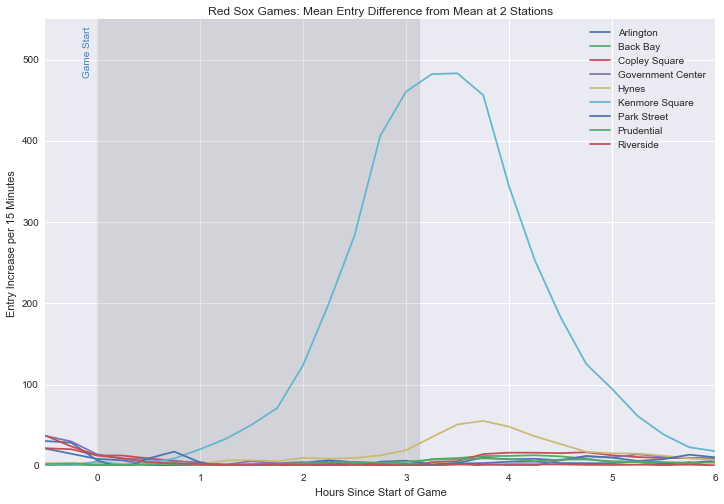

In [100]:
# Plot all stations that show significant lift.

# Lift threshold.
lift_threshold = 100

# Start plotting.
plt.figure(figsize=default_figsize)

# Add lines for each station.
stations_plotted = 0
for station in mean_entry_differences_dow.name.unique():
    # Get station entries.
    station_entry_differences = mean_entry_differences_dow[mean_entry_differences_dow.name == station]
    # Get agg lift.
    station_lift = int(station_entry_differences.entries_vs_mean_season['mean'].sum())
    # Only plot those above threshold.
    if station_lift >= lift_threshold:
        stations_plotted += 1
        # Plot.
        plt.plot(station_entry_differences.hours_since_game_start, station_entry_differences.entries_vs_mean_season['mean'], label=station)
        # Add note about total over time range.
        print station+' mean increase in entries across time period:',station_lift
    
# Fix x limit and add origin lines.
xlim = plt.xlim((-0.5, plt.xlim()[1])); ylim = (0,plt.ylim()[1]*1.1)
# plt.axvline(0, *ylim, color='lightgray')
plt.axvspan(0, game_length, color='k', alpha=0.1)
# plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (-.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue')

# Prettify.
plt.title('Red Sox Games: Mean Entry Difference from Mean at %d Stations' % len(fenway_stations))
plt.xlabel('Hours Since Start of Game'); plt.ylabel('Entry Increase per 15 Minutes')
plt.ylim(ylim)
plt.legend()

# Show.
plt.show()

In [102]:
# For added context, sum the mean difference for all stations.
print 'Mean increase in entries across time period for stations:'
for station in fenway_stations:
    print station+':',
    print mean_entry_differences_dow[mean_entry_differences_dow.name == station].entries_vs_mean_season['mean'].sum()

Mean increase in entries across time period for stations:
Kenmore Square: 4232.98394969
Hynes: 430.510969317


Total: **4,660**

Plot a version for slides:

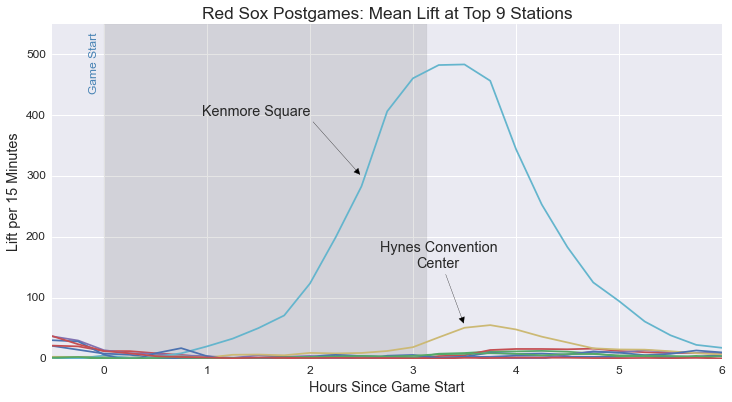

In [156]:
# Plot all stations that show significant lift.

# Start plotting.
plt.figure(figsize=default_figsize_slides)

# Add lines for each station.
for station in mean_entry_differences_dow.name.unique():
    # Get station entries.
    station_entry_differences = mean_entry_differences_dow[mean_entry_differences_dow.name == station]
    # Get agg lift.
    station_lift = int(station_entry_differences.entries_vs_mean_season['mean'].sum())
    # Only plot those above threshold.
    if station_lift >= lift_threshold:
        # Plot.
        plt.plot(station_entry_differences.hours_since_game_start, station_entry_differences.entries_vs_mean_season['mean'], label=station)
    
# Fix x limit and add origin lines.
xlim = plt.xlim((-0.5, plt.xlim()[1])); ylim = (0,plt.ylim()[1]*1.1)
# plt.axvline(0, *ylim, color='lightgray')
plt.axvspan(0, game_length, color='k', alpha=0.1)
# plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (-.05,ylim[1]*0.95), rotation='vertical', ha='right', color='steelblue', fontsize='large')

# Annotations for Kenmore, Hynes.
plt.annotate('Kenmore Square', xy=(2.5,300), xytext=(2,400), ha='right', fontsize='x-large', arrowprops=dict(facecolor='black', arrowstyle='-|>', relpos=(1,0)))
plt.annotate('Hynes Convention\nCenter', xy=(3.5,55), xytext=(3.25,150), ha='center', fontsize='x-large', arrowprops=dict(facecolor='black', arrowstyle='-|>'))

# Prettify.
plt.title('Red Sox Postgames: Mean Lift at Top %d Stations' % stations_plotted, fontsize='xx-large')
plt.xlabel('Hours Since Game Start', fontsize='x-large'); plt.ylabel('Lift per 15 Minutes', fontsize='x-large')
plt.ylim(ylim)
# plt.legend(fontsize='large')
plt.xticks(fontsize='large'); plt.yticks(fontsize='large')

# Show.
plt.show()

#### Distributions

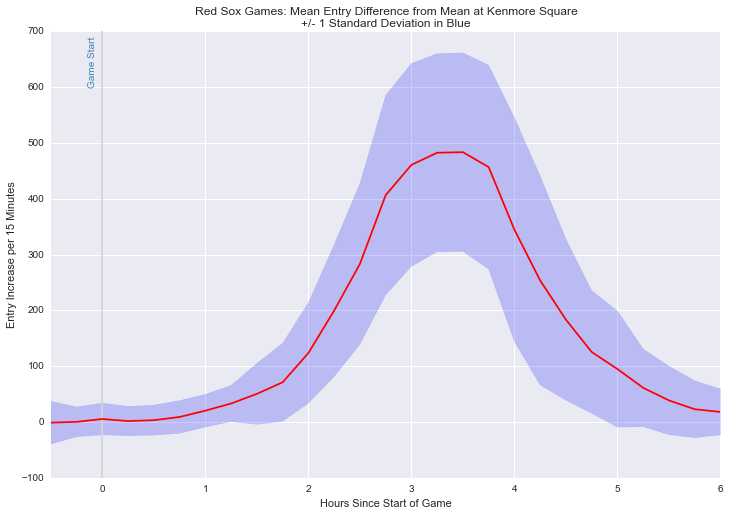

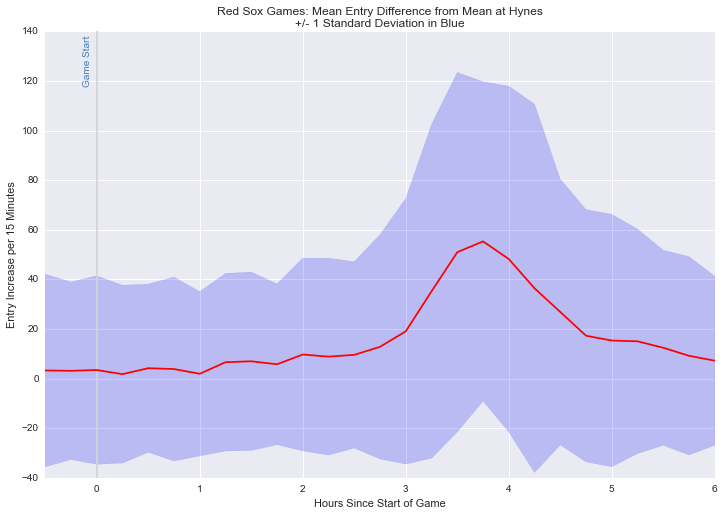

In [105]:
# Plot once per station.
for station in fenway_stations:
    # Get station entries and upper/lower bounds. Follows Fil's examples in GateCount_exploratory_fil.
    station_entry_differences = mean_entry_differences_dow[mean_entry_differences_dow.name == station]
    upper = station_entry_differences.entries_vs_mean_season['mean'] - station_entry_differences.entries_vs_mean_season['std']
    lower = station_entry_differences.entries_vs_mean_season['mean'] + station_entry_differences.entries_vs_mean_season['std']

    # Start plotting.
    plt.figure(figsize=default_figsize)
    plt.plot(station_entry_differences.hours_since_game_start, station_entry_differences.entries_vs_mean_season['mean'], 'r')
    plt.fill_between(station_entry_differences.hours_since_game_start, upper, lower, color='b', alpha=0.2)
    
    # Fix x limit and add origin lines.
    xlim = plt.xlim((-0.5, plt.xlim()[1])); ylim = plt.ylim()
    plt.vlines(0, *ylim, colors='lightgray')
    # plt.hlines(0, *xlim, colors='lightgray')
    plt.annotate('Game Start', (-.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue')

    # Prettify.
    plt.title('Red Sox Games: Mean Entry Difference from Mean at '+station+'\n+/- 1 Standard Deviation in Blue')
    plt.xlabel('Hours Since Start of Game'); plt.ylabel('Entry Increase per 15 Minutes')
    plt.ylim(ylim)

    # Show.
    plt.show()

Slide version:

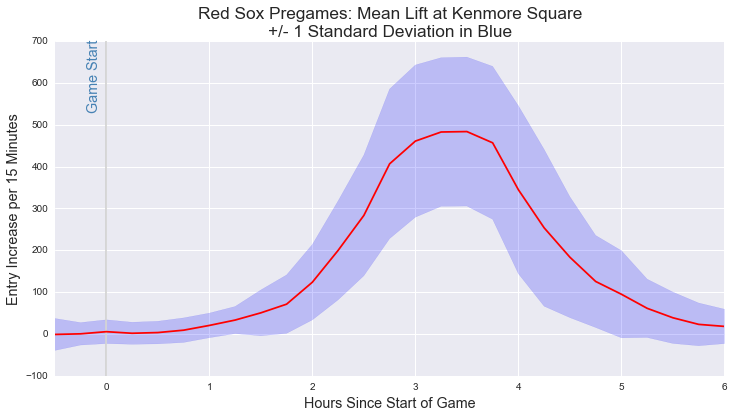

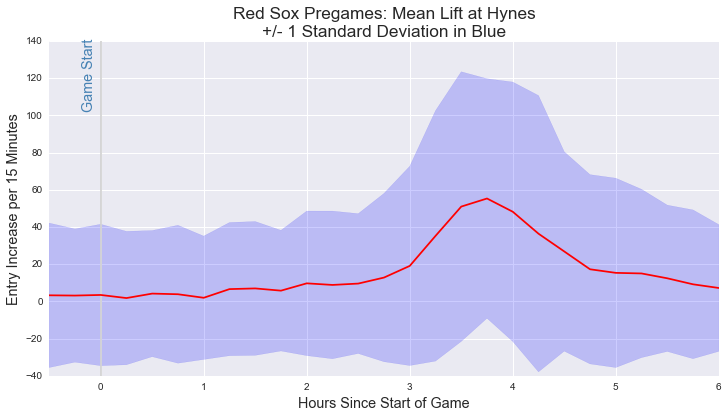

In [108]:
# Plot once per station.
for station in fenway_stations:
    # Get station entries and upper/lower bounds. Follows Fil's examples in GateCount_exploratory_fil.
    station_entry_differences = mean_entry_differences_dow[mean_entry_differences_dow.name == station]
    upper = station_entry_differences.entries_vs_mean_season['mean'] - station_entry_differences.entries_vs_mean_season['std']
    lower = station_entry_differences.entries_vs_mean_season['mean'] + station_entry_differences.entries_vs_mean_season['std']

    # Start plotting.
    plt.figure(figsize=default_figsize_slides)
    plt.plot(station_entry_differences.hours_since_game_start, station_entry_differences.entries_vs_mean_season['mean'], 'r')
    plt.fill_between(station_entry_differences.hours_since_game_start, upper, lower, color='b', alpha=0.2)
    
    # Fix x limit and add origin lines.
    xlim = plt.xlim((-0.5, plt.xlim()[1])); ylim = plt.ylim()
    plt.vlines(0, *ylim, colors='lightgray')
    # plt.hlines(0, *xlim, colors='lightgray')
    plt.annotate('Game Start', (-.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue', fontsize='x-large')

    # Prettify.
    plt.title('Red Sox Pregames: Mean Lift at '+station+'\n+/- 1 Standard Deviation in Blue', fontsize='xx-large')
    plt.xlabel('Hours Since Start of Game', fontsize='x-large'); plt.ylabel('Entry Increase per 15 Minutes', fontsize='x-large')
    plt.ylim(ylim)

    # Show.
    plt.show()

Finally, plot proportional change.

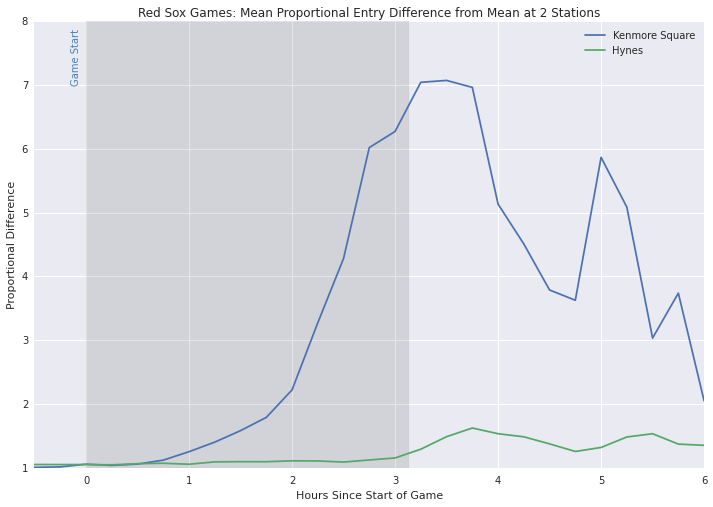

In [61]:
# Now plot them. Plot one line per station.

# Start plotting.
plt.figure(figsize=default_figsize)

# Add lines for each station.
for station in fenway_stations:
    # Get station entries.
    station_entry_differences = mean_entry_differences_dow[mean_entry_differences_dow.name == station]
    plt.plot(station_entry_differences.hours_since_game_start, station_entry_differences.entries_vs_mean_ratio['mean'], label=station)
    
# Fix x limit and add origin lines.
xlim = plt.xlim((-0.5, plt.xlim()[1])); ylim = plt.ylim()
# plt.vlines(0, *ylim, colors='lightgray')
plt.axvspan(0, game_length, color='k', alpha=0.1)
# plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (-.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue')

# Prettify.
plt.title('Red Sox Games: Mean Proportional Entry Difference from Mean at %d Stations'%len(fenway_stations))
plt.xlabel('Hours Since Start of Game'); plt.ylabel('Proportional Difference')
plt.ylim(ylim)
plt.legend()

# Show.
plt.show()

### Specific Game Times

Let's go beyond aggregate games and consider more specific starting times. This is useful because it aligns with how we might model daily entries, and how planners might accommodate specific games. To maximize utility, we'll analyze 7:00pm games on Monday-Saturday, and 1:30pm games on Sunday.

In [129]:
# Store games to analyze.
day_time_pairs = [(d,dt.time(19)) for d in xrange(6)]
day_time_pairs.append((6,dt.time(13,30)))

In [130]:
# Get hourly entries for all days and times of day on gameless days. Use name to indicate stations.
gameless_entries_dow = fenway_games[fenway_games.game_played == False]
gameless_entries_dow = gameless_entries_dow.groupby(['name','day_of_week','service_time']).agg({'entries': np.mean}).reset_index()
gameless_entries_dow.rename(columns={'entries':'mean_entries'}, inplace=True)

In [135]:
game_entries_dow.columns

Index([u'locationid', u'name', u'service_day', u'service_datetime', u'entries', u'service_time', u'day_of_week', u'game_date', u'game_time', u'opponent', u'game_datetime', u'game_time_rounded', u'game_datetime_rounded', u'game_played', u'time_since_game_start', u'day_of_week_class', u'game_time_class'], dtype='object')

In [136]:
# Only consider entries at the time of or soon after the game.
gametime_condition = (fenway_games.time_since_game_start >= np.timedelta64(-30,'m')) & (fenway_games.time_since_game_start <= np.timedelta64(6,'h'))
# We also need to set up a condition for day of week and game time.
game_day_time_condition = pd.Series([False]*len(fenway_games))
for d,t in day_time_pairs:
    game_day_time_condition = game_day_time_condition | ((fenway_games.day_of_week == d) & (fenway_games.game_time_rounded == t))# Filter games.
# Apply above conditions and ONLY CONSIDER KENMORE FOR NOW.
game_entries_dow = fenway_games[fenway_games.game_played & gametime_condition & game_day_time_condition & (fenway_games.name == 'Kenmore Square')]

# Join mean entries for gameless days at that time of day.
entry_differences_dow = game_entries_dow.merge(gameless_entries_dow, on=['name','day_of_week','service_time'])[['name','day_of_week','game_time_rounded','entries','time_since_game_start','mean_entries']]
entry_differences_dow['entries_vs_mean'] = entry_differences_dow.entries - entry_differences_dow.mean_entries
entry_differences_dow['entries_vs_mean_ratio'] = entry_differences_dow.entries / entry_differences_dow.mean_entries

# Calculate mean differences and clean up timedeltas that don't place nicely with groupings.
mean_entry_differences_dow = entry_differences_dow.groupby(['name','day_of_week','game_time_rounded','time_since_game_start']).agg({
        'entries_vs_mean': [np.mean,np.std],
        'entries_vs_mean_ratio': [np.mean,np.std]
    }).reset_index()
mean_entry_differences_dow.time_since_game_start = pd.to_timedelta(mean_entry_differences_dow.time_since_game_start)
mean_entry_differences_dow['hours_since_game_start'] = mean_entry_differences_dow.time_since_game_start.astype(np.int) / timedelta_base

In [ ]:
mean_entry_differences_dow

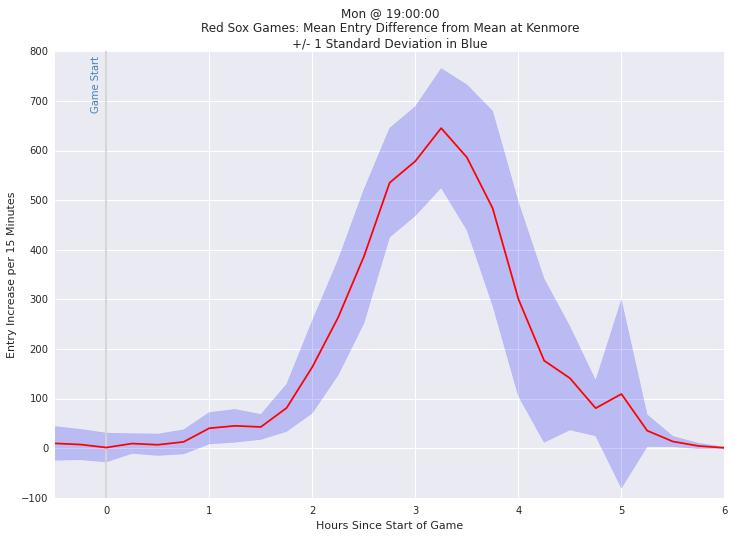

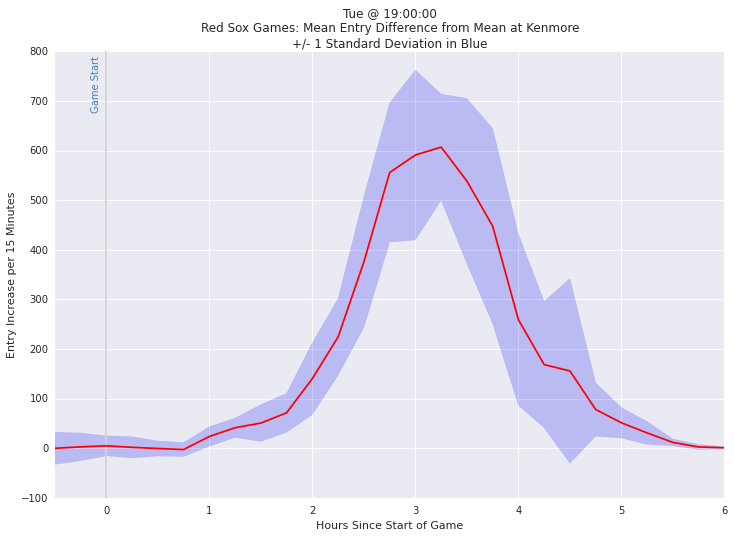

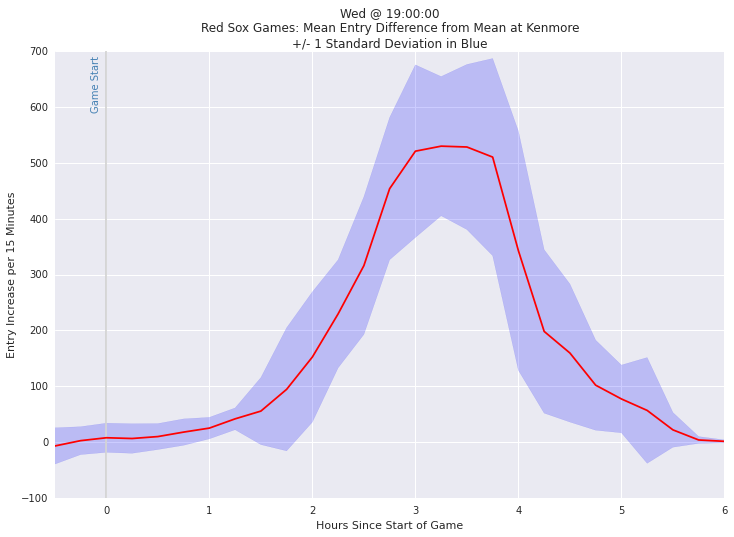

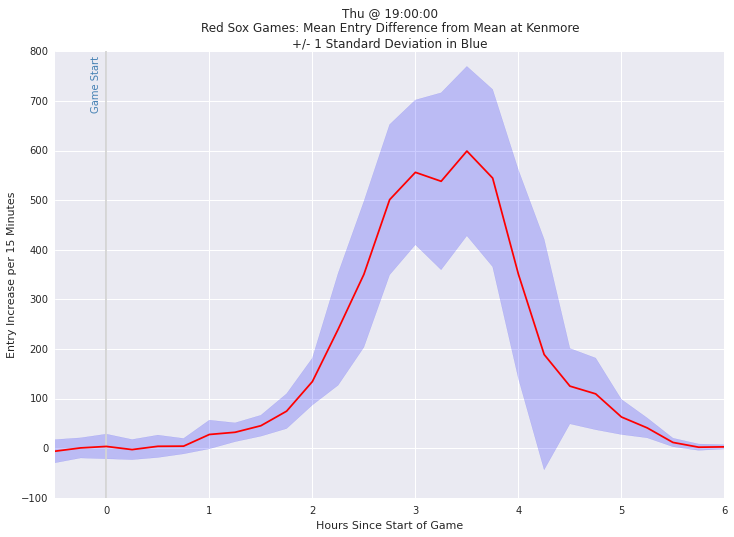

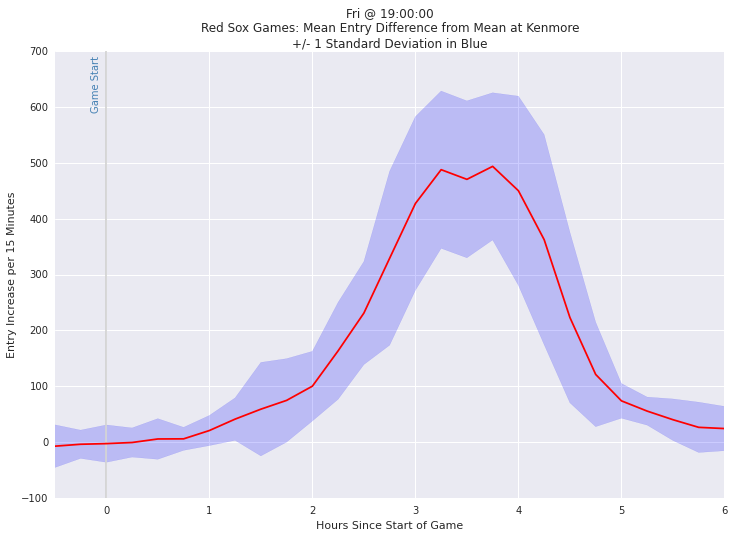

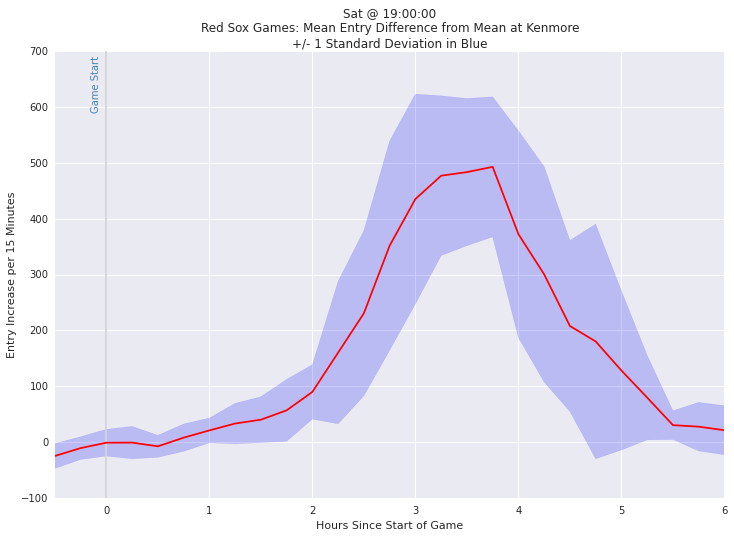

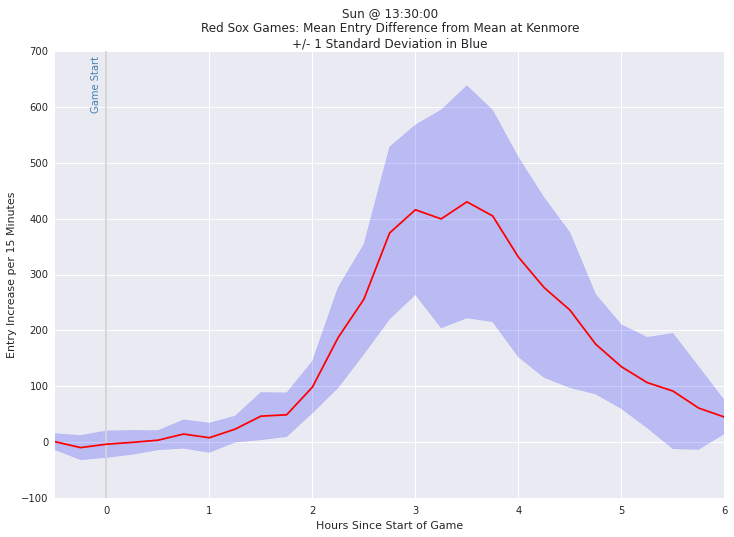

In [137]:
# Plot once per day of week.
for d,t in day_time_pairs:
    # Get station entries and upper/lower bounds. Follows Fil's examples in GateCount_exploratory_fil.
    game_dow_time_entry_differences = mean_entry_differences_dow[(mean_entry_differences_dow.day_of_week == d) & (mean_entry_differences_dow.game_time_rounded == t)]
    upper = game_dow_time_entry_differences.entries_vs_mean['mean'] - game_dow_time_entry_differences.entries_vs_mean['std']
    lower = game_dow_time_entry_differences.entries_vs_mean['mean'] + game_dow_time_entry_differences.entries_vs_mean['std']

    # Start plotting.
    plt.figure(figsize=default_figsize)
    plt.plot(game_dow_time_entry_differences.hours_since_game_start, game_dow_time_entry_differences.entries_vs_mean['mean'], 'r')
    plt.fill_between(game_dow_time_entry_differences.hours_since_game_start, upper, lower, color='b', alpha=0.2)
    
    # Fix x limit and add origin lines.
    xlim = plt.xlim((-0.5, plt.xlim()[1])); ylim = plt.ylim()
    plt.vlines(0, *ylim, colors='lightgray')
    # plt.hlines(0, *xlim, colors='lightgray')
    plt.annotate('Game Start', (-.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue')

    # Prettify.
    plt.title(days_of_week[d]+' @ '+str(t)+'\nRed Sox Games: Mean Entry Difference from Mean at Kenmore\n+/- 1 Standard Deviation in Blue')
    plt.xlabel('Hours Since Start of Game'); plt.ylabel('Entry Increase per 15 Minutes')
    # plt.ylim(ylim)

    # Show.
    plt.show()

### Aggregate Distribution

Now let's calculate the distribution of additional entries per game. Each observation is a *game* in this case, and each measurement is the sum of entries above mean over the 6.5 hour period above.

In [115]:
# We can reuse some tables from above. game_entries_dow will suit our needs but we'll need to derive another df for games.

# Only consider entries at the time of or soon after the game.
gametime_condition = (fenway_games.time_since_game_start >= np.timedelta64(-30,'m')) & (fenway_games.time_since_game_start <= np.timedelta64(6,'h'))
all_games_entries = fenway_games[fenway_games.game_played & gametime_condition]

# Get differences from means.
entry_differences_fields = ['game_date','day_of_week_class','game_time_class','entries','mean_entries_all','mean_entries_season']
entry_differences_class = all_games_entries.merge(gameless_entries_dow, on=['name','day_of_week','service_time'])[entry_differences_fields]
entry_differences_class['entries_vs_mean_season'] = entry_differences_class.entries - entry_differences_class.mean_entries_season

# Now aggregate by game and class, and sum entries vs. mean.
agg_entry_differences = entry_differences_class.groupby(['game_date','day_of_week_class','game_time_class']).agg({'entries_vs_mean_season': np.sum}).reset_index()

# Generate a new class field for grouping.
agg_entry_differences['game_class'] = agg_entry_differences.day_of_week_class + ' ' + agg_entry_differences.game_time_class

# Get classes to plot.
game_classes = set(agg_entry_differences.game_class)

In [ ]:
agg_entry_differences.head()

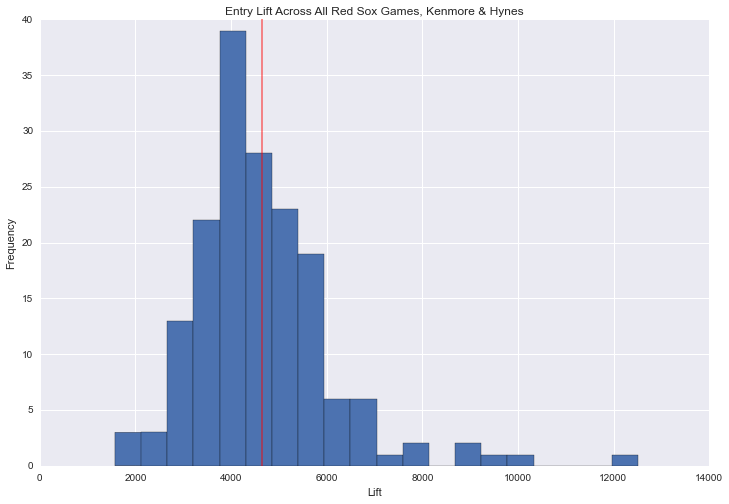

In [129]:
# Start plotting.
plt.figure(figsize=default_figsize)
plt.hist(agg_entry_differences.entries_vs_mean_season, bins=20)
# Prettify.
plt.title('Entry Lift Across All Red Sox Games, Kenmore & Hynes')
plt.xlabel('Lift'); plt.ylabel('Frequency')
# Annotate.
ylim = plt.ylim()
plt.axvline(agg_entry_differences.entries_vs_mean_season.mean(), ylim[0], ylim[1], c='r', alpha=0.5)
# Show.
plt.show()

Slide version:

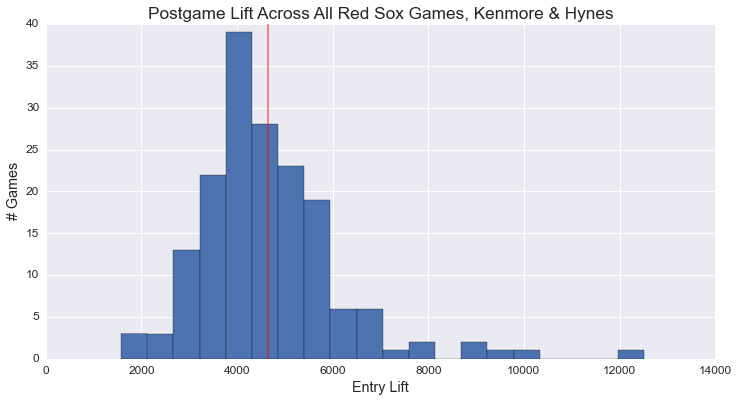

In [157]:
# Start plotting.
plt.figure(figsize=default_figsize_slides)
plt.hist(agg_entry_differences.entries_vs_mean_season, bins=20)
# Prettify.
plt.title('Postgame Lift Across All Red Sox Games, Kenmore & Hynes', fontsize='xx-large')
plt.xlabel('Entry Lift', fontsize='x-large'); plt.ylabel('# Games', fontsize='x-large')
plt.xticks(fontsize='large'); plt.yticks(fontsize='large')
# Annotate.
ylim = plt.ylim()
plt.axvline(agg_entry_differences.entries_vs_mean_season.mean(), ylim[0], ylim[1], c='r', alpha=0.5)
# Show.
plt.show()

In [122]:
agg_entry_differences.sort(columns='entries_vs_mean_season', ascending=False).head(n=20)

,game_date,day_of_week_class,game_time_class,entries_vs_mean_season,game_class
98,2014-04-21,Weekday,Early,12514.639899,Weekday Early
96,2014-04-19,Weekend,Early,9934.677419,Weekend Early
3,2013-04-13,Weekend,Early,9707.967742,Weekend Early
4,2013-04-14,Weekend,Early,8969.909091,Weekend Early
89,2014-04-04,Weekday,Early,8899.036984,Weekday Early
95,2014-04-18,Weekday,Late,8029.632290,Weekday Late
90,2014-04-05,Weekend,Late,7698.951613,Weekend Late
88,2013-10-30,Weekday,Late,7272.955916,Weekday Late
101,2014-04-24,Weekday,Late,6966.425578,Weekday Late
73,2013-09-14,Weekend,Early,6911.967742,Weekend Early


Looks like Patriots Day last year is the big outlier. Lots of other April games in the top tier—this could be picking up on a seasonal effect rather than truly significant games.